In [11]:
using Measurements

x = 1.0 ± 0.1      # convenience notation for measurement(1.0,0.1)

@show x sin(x);


LoadError: UndefVarError: `±` not defined

In [8]:
##  loss function
import Zygote
using Optim
using  Distributions , DifferentialEquations , ForwardDiff
using Measurements

function loss_function(params)
    r, K = params
    loss = 0.0 ± 0.0
    dudt(u,(r,K,H),t) = r * u * (K - u) - H  # fishery diff function
    u = [264410.0 ±  10000.0 , 247132.0 ±  10000.0, 241466.0 ±  10000.0, 208014.0 ±  10000.0, 189986.0 ±  10000.0]
    for i in 1:5
        u0 = u[i]
        H = [20000, 50000, 80000, 110000, 140000][i]
        
        prob = ODEProblem(dudt, u0, (0.0, 5.0), [r, K, H])
        sol = solve(prob, Tsit5())
        predicted_population = sol[end][1]   # get predicted P from diff function
        loss += abs( predicted_population - u[5] )
    end
    # return sum of loss
    println(loss)
    return loss
end

# initializa for r ,K
initial_guess = [0.2 ± 0.1, 100000.0 ± 10000.0]  

# minimize loss
#test = loss_function(initial_guess)
result = optimize(loss_function, initial_guess)



LoadError: UndefVarError: `±` not defined

In [ ]:
# optimization
optimal_params = Optim.minimizer(result)
println("Optimal r and K: ", optimal_params)

In [89]:
### new algorithm

##  loss function
import Zygote
using Optim
using MonteCarloMeasurements, Distributions , DifferentialEquations , ForwardDiff
using Measurements
function loss_function(params)
    r, K = params
    loss_arr = [1.0 ± 1.0, 1.0 ± 1.0, 1.0 ± 1.0, 1.0 ± 1.0, 1.0 ± 1.0]
    loss = 0.0 ± 0.0
    dudt(u,(r,K,H),t) = r * u * (K - u) - H  # fishery diff function
    p = [264410.0 ±  10000.0 , 247132.0 ±  10000.0, 241466.0 ±  10000.0, 208014.0 ±  10000.0, 189986.0 ±  10000.0] 
    p0 = p[1]
    H = [20000, 50000, 80000, 110000, 140000][1]
    #println("harvest:",H)
    prob = ODEProblem(dudt, p0, (0.0, 5.0), [r, K, H])
    sol = solve(prob, Tsit5())
    
    for i in 1:5
        predicted_population = sol[i][1]   # get predicted P from diff function
        main_loss = sqrt( (predicted_population - p[i])^2 )
        loss += main_loss
        #println("loss:",main_loss)
        #loss = (predicted_population - u0)^2  # compute loss one by one
        #push!(losses, loss)
    end
    println(loss)
    # return sum of loss
    return loss
end

# initializa for r ,K
initial_guess = [0.1 ± 0.1, 100000.0 ± 10000.0]  

# minimize loss
result = optimize(loss_function, initial_guess)
println(result)
# optimization
optimal_params = Optim.minimizer(result)
#println("Optimal r and K: ", optimal_params)


harvest:20000
168000.0 ± 310000.0
harvest:20000

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\12\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:600



158000.0 ± 230000.0
harvest:20000


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\12\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:600


165000.0 ± 700000.0

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\12\.julia\packages\SciMLBase\Dwomw\src\integrator_interface.jl:600


LoadError: InterruptException:

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


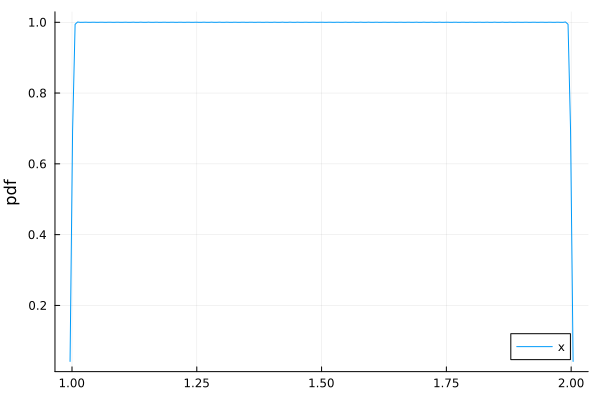

In [6]:
using StatsPlots
density(x; label="x", bandwidth=0.001, ylabel="pdf")